# Mixtec Gender Classification

### Imports

In [29]:
%matplotlib inline
# %pip install pandas numpy torcheval torch matplotlib
import os

from pathlib import Path
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler

torch.manual_seed(42)

### Define hardware

In [2]:
!pwd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

/orange/ufdatastudios/alexwebber/mixteclabeling/notebooks
Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define path to images

In [3]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

### Load figures into pandas, visualize

In [4]:
# Random Block Transform
class AddRandomBlockNoise(torch.nn.Module):
    def __init__(self, n_k=8, size=64):
        super(AddRandomBlockNoise, self).__init__()
        self.n_k = int(n_k * np.random.rand()) # Random number of boxes
        self.size = int(size * np.random.rand()) # Max size
    
    def forward(self, tensor):
        h, w = self.size, self.size
        img = np.asarray(tensor)
        img_size_x = img.shape[1]
        img_size_y = img.shape[2]
        boxes = []
        for k in range(self.n_k):
            if (img_size_y >= h or img_size_x >=w): break
            print(f"{h=} {w=} {img_size_x=} {img_size_y=}")
            x = np.random.randint(0, img_size_x-w, 1)[0] # FIXME the shape may be zero
            y = np.random.randint(0, img_size_y-h, 1)[0]
            img[:, y:y+h, x:x+w] = 0
            boxes.append((x,y,h,w))
        #img = Image.fromarray(img.astype('uint8'), 'RGB')
        return torch.from_numpy(img)
    
    def __repr__(self):
        return self.__class__.__name__ + '(blocks={0}, size={1})'.format(self.n_k, self.size)

In [5]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures.groupby('quality')['gender'].value_counts())
print('\n')
print(mixtec_figures['gender'].value_counts())
print('\n')
print(mixtec_figures['quality'].value_counts())

## Load Tensorboard output
writer = SummaryWriter('runs/mixtec_experiment_gender')


quality  gender
a        male      427
         female    220
b        male       68
         female     47
c        female      8
         male        4
Name: count, dtype: int64


gender
male      499
female    275
Name: count, dtype: int64


quality
a    647
b    115
c     12
Name: count, dtype: int64


### Load figures into datasets by codex

In [6]:
## Define image transforms
## List of transforms https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     AddRandomBlockNoise(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     
     #transforms.ColorJitter(contrast=0.5),
     #transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     #transforms.RandomHorizontalFlip(50),
     #transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

### Concatenate datasets

In [7]:
figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

print(figures_dataset)

### Assign classes to map

In [8]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

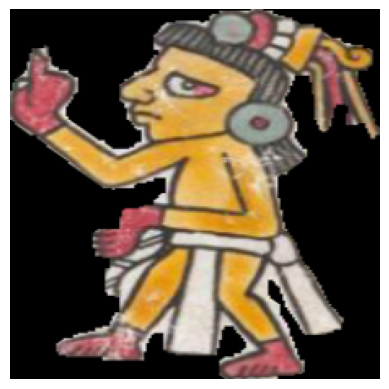

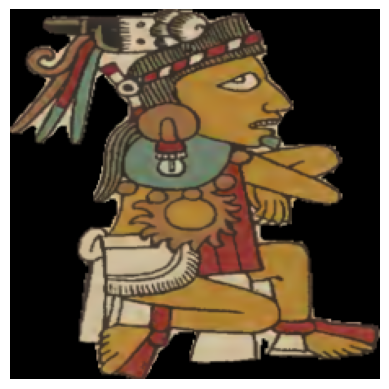

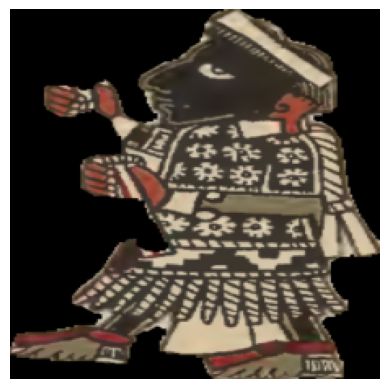

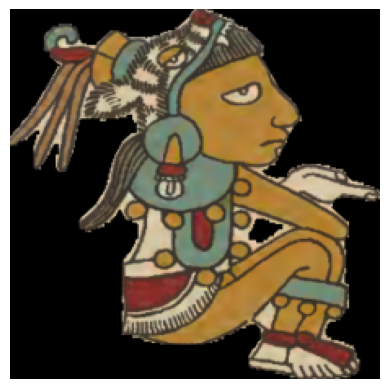

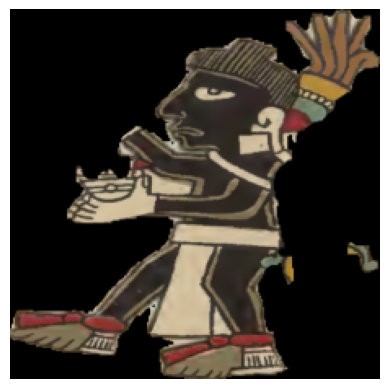

In [9]:
# Access a random image from the dataset

for i in range(5):
    random_index = np.random.randint(len(figures_dataset))
    image, label = figures_dataset[random_index]

    # Convert the image tensor to a NumPy array and transpose it
    image = image.permute(1, 2, 0)
    image = image.numpy()

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Visualize dataloaders

In [10]:
def count_classes(dataset, n_classes=2):
    image_count = [0]*(n_classes)
    for img in dataset:
        image_count[img[1]] += 1
    return image_count

def sampler_(dataset, n_classes=2):
    dataset_counts = count_classes(dataset)
    num_samples = len(dataset_counts)
    labels = [tag for _,tag in dataset]

    class_weights = [num_samples/dataset_counts[i] for i in range(n_classes)]
    weights = [class_weights[labels[i]] for i in range(num_samples)]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)
    return sampler

### Split combined dataset into training and testing sets and load into DataLoaders

In [11]:
batch_size = 128

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

sampler = sampler_(train_set.dataset)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size,  shuffle = True)

# Training

### Define functions for visualizing loss

In [12]:
def plot_training_perf(train_loss, fs=(8,5)):
    plt.figure(figsize=fs)


    # assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = len(train_loss)
    epochs = np.arange(0, num_epochs)
    
    # Can you figure out why this makes sense? Why remove -0.5?
    plt.plot(epochs + 1, train_loss, 'm', linewidth=2,  label='Loss (Training)')
    #plt.plot(epochs-0.5, train_acc, 'r--', linewidth=2, label='Accuracy (Training)')
    
    
    plt.xlim([1, num_epochs])
    #plt.ylim([0, 1.05])
    
    plt.legend()
    
    plt.show()

### Define CNN

In [13]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        
        x = self.dropout2(x)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x




### Create the model

In [14]:
# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

### Define hyperparameters

In [15]:
lossweight = torch.tensor([1.5,1.0]).to(device)
#lossweight.to(device)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(cnn.parameters())

### Train model

In [28]:
losses = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward
        outputs = cnn(inputs)
        
        # metrics
        train_loss = criterion(outputs, labels)
        #train_accuracy = torch.sum(outputs == labels)
        running_loss += train_loss.item()
        
        # backward
        optimizer.zero_grad()
        train_loss.backward()
        
        # gradient descent or adam step
        optimizer.step()

        # print statistics
        
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
            
            losses.append(running_loss)
        
            running_loss = 0.0

print('Finished Training')

Epoch: 1 | Loss: 0.024924345314502716
Epoch: 2 | Loss: 0.028588030487298965
Epoch: 3 | Loss: 0.024518433958292007
Epoch: 4 | Loss: 0.029100239276885986
Epoch: 5 | Loss: 0.03068222850561142
Epoch: 6 | Loss: 0.03035653941333294
Epoch: 7 | Loss: 0.025823883712291718
Epoch: 8 | Loss: 0.02361450530588627
Epoch: 9 | Loss: 0.027200182899832726
Epoch: 10 | Loss: 0.02871648781001568
Epoch: 11 | Loss: 0.025192633271217346
Epoch: 12 | Loss: 0.024276699870824814
Epoch: 13 | Loss: 0.026468167081475258
Epoch: 14 | Loss: 0.025823500007390976
Epoch: 15 | Loss: 0.025729836896061897
Epoch: 16 | Loss: 0.028607867658138275
Epoch: 17 | Loss: 0.024883722886443138
Epoch: 18 | Loss: 0.02391093038022518
Epoch: 19 | Loss: 0.027490127831697464
Epoch: 20 | Loss: 0.02623141184449196
Epoch: 21 | Loss: 0.025150718167424202
Epoch: 22 | Loss: 0.02404702454805374
Epoch: 23 | Loss: 0.02872815728187561
Epoch: 24 | Loss: 0.026522450149059296
Epoch: 25 | Loss: 0.02175091579556465
Epoch: 26 | Loss: 0.029836345463991165
Epoc

TypeError: len() of a 0-d tensor

### View loss & accuracy over time

In [36]:
for n_iter in range(len(losses)):
    writer.add_scalar('Loss/train', losses[n_iter], n_iter)
    # writer.add_scalar('Accuracy/train', np.random.random(), n_iter)

### View incorrectly labeled samples

In [39]:
cnn.eval()

!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
/home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.25' not found (required by /home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.18' not found (required by /home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.29' not found (required by /home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/alexwebber/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.33' not found (required by /home/alexwebber/.local/lib/python3.10/site-packages/tensor

In [18]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [19]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

### Define tensorboard output function

In [21]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="inferno")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

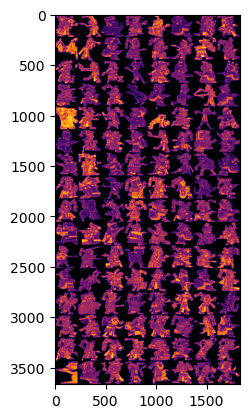

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [23]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [24]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

### Produce predictions and calculate accuracy of model

In [25]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

tensor([18.6048, 18.4776, 14.6334, 17.7504, 17.8889, 19.3128, 15.4814, 19.4109,
        18.3114, 18.1882, 18.7246, 20.6960, 14.6675, 20.8666, 17.1039, 18.0831,
        17.9622, 14.4125, 16.7900, 14.5875, 16.8845, 15.4297, 22.7279, 13.4919,
        18.2513, 24.9872, 21.9887, 21.8692, 17.8551, 17.6216, 19.4729, 17.5638,
        19.2548, 20.2548, 19.8585, 16.4666, 18.6021, 14.9025, 19.1745, 19.2759,
        22.7386, 19.6004, 21.5898, 18.9305, 18.4668, 17.8145, 19.3584, 16.8874,
        19.1861, 18.3120, 16.0790, 16.7813, 18.6527, 21.4004, 17.0823, 21.7613,
        18.8672, 17.8336, 18.8799, 16.5710, 14.6939, 18.6756, 17.6080, 18.1911,
        18.0272, 22.3775, 14.7519, 18.7166, 21.3018, 17.7878, 18.5588, 22.4502,
        15.5458, 21.1317, 21.1633, 17.6170, 19.3294, 22.1131, 17.3045, 13.6535,
        15.1085, 14.6583, 19.3165, 18.3683, 17.3689, 16.6696, 21.9733, 21.5155,
        18.9324, 16.1784, 18.5703, 20.1946, 19.5857, 21.9434, 17.9674, 19.1370,
        21.1164, 18.6235, 17.7590, 19.29

In [26]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Predicted: tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])
Truth    : tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1])
Accuracy : 0.8467153310775757
Precision: 0.892473101615905